In [1]:
import cv2
from glob import glob
from h5py import File
import keras
from keras.applications.imagenet_utils import preprocess_input
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
import tensorflow as tf

from gradient_reversal_layer import GRWeightScheduler
from map_callback import MAPCallback
from sdsnet import SDSnet
from ssd_dann import SSD300_DANN
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
# some constants
NUM_CLASSES = 4
input_shape = (300, 300, 3)

In [3]:
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [4]:
gt = pickle.load(open('gt_pascal.pkl', 'rb'))
keys = sorted(gt.keys())
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)
adapt_keys = glob('../../adapt_frames/*.png')
num_adapt = len(adapt_keys)

In [5]:
class Generator(object):
    def __init__(self, gt, bbox_util,
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size,
                 adapt_keys=None,
                 saturation_var=0.5,
                 brightness_var=0.5,
                 contrast_var=0.5,
                 lighting_std=0.5,
                 hflip_prob=0.5,
                 vflip_prob=0.5,
                 do_crop=True,
                 crop_area_range=[0.75, 1.0],
                 aspect_ratio_range=[3./4., 4./3.],
                 dann=False, segment=False):
        self.gt = gt
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.adapt_keys = adapt_keys
        self.train_samples = len(train_keys)
        self.val_samples = len(val_keys)
        self.adapt_samples = 0 if adapt_keys is None else len(adapt_keys)
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
        self.dann = dann
        self.segment = segment
        if dann and adapt_keys is None:
            raise Exception('Keys for domain adaptation must be provided')
        if self.segment:
            self.seg_db = File('seg_gt.h5', mode='r')
        
    def grayscale(self, rgb):
        return rgb.dot([0.299, 0.587, 0.114])

    def saturation(self, rgb):
        gs = self.grayscale(rgb)
        alpha = 2 * np.random.random() * self.saturation_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
        return np.clip(rgb, 0, 255)

    def brightness(self, rgb):
        alpha = 2 * np.random.random() * self.brightness_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha
        return np.clip(rgb, 0, 255)

    def contrast(self, rgb):
        gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
        alpha = 2 * np.random.random() * self.contrast_var 
        alpha += 1 - self.contrast_var
        rgb = rgb * alpha + (1 - alpha) * gs
        return np.clip(rgb, 0, 255)

    def lighting(self, img):
        cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
        eigval, eigvec = np.linalg.eig(cov)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigvec.dot(eigval * noise) * 255
        img += noise
        return np.clip(img, 0, 255)
    
    def horizontal_flip(self, img, y):
        if np.random.random() < self.hflip_prob:
            img = img[:, ::-1]
            y[:, [0, 2]] = 1 - y[:, [2, 0]]
        return img, y
    
    def vertical_flip(self, img, y):
        if np.random.random() < self.vflip_prob:
            img = img[::-1]
            y[:, [1, 3]] = 1 - y[:, [3, 1]]
        return img, y
    
    def random_sized_crop(self, img, targets):
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_area = img_w * img_h
        random_scale = np.random.random()
        random_scale *= (self.crop_area_range[1] -
                         self.crop_area_range[0])
        random_scale += self.crop_area_range[0]
        target_area = random_scale * img_area
        random_ratio = np.random.random()
        random_ratio *= (self.aspect_ratio_range[1] -
                         self.aspect_ratio_range[0])
        random_ratio += self.aspect_ratio_range[0]
        w = np.round(np.sqrt(target_area * random_ratio))     
        h = np.round(np.sqrt(target_area / random_ratio))
        if np.random.random() < 0.5:
            w, h = h, w
        w = min(w, img_w)
        w_rel = w / img_w
        w = int(w)
        h = min(h, img_h)
        h_rel = h / img_h
        h = int(h)
        x = np.random.random() * (img_w - w)
        x_rel = x / img_w
        x = int(x)
        y = np.random.random() * (img_h - h)
        y_rel = y / img_h
        y = int(y)
        img = img[y:y+h, x:x+w]
        new_targets = []
        for box in targets:
            cx = 0.5 * (box[0] + box[2])
            cy = 0.5 * (box[1] + box[3])
            if (x_rel < cx < x_rel + w_rel and
                y_rel < cy < y_rel + h_rel):
                xmin = (box[0] - x_rel) / w_rel
                ymin = (box[1] - y_rel) / h_rel
                xmax = (box[2] - x_rel) / w_rel
                ymax = (box[3] - y_rel) / h_rel
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(1, xmax)
                ymax = min(1, ymax)
                box[:4] = [xmin, ymin, xmax, ymax]
                new_targets.append(box)
        new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
        return img, new_targets
    
    def generate(self, train):
        while True:
            if train:
                shuffle(self.train_keys)
                if self.dann:
                    shuffle(self.adapt_keys)
                keys = self.train_keys
            else:
                shuffle(self.val_keys)
                keys = self.val_keys
            inputs = []
            targets = []
            seg_targets = []
            if self.dann and train:
                adapt_inputs = []
                adapt_targets = []
            for key_num, key in enumerate(keys):            
                img_path = self.path_prefix + key
                img = imread(img_path).astype('float32')
                y = self.gt[key].copy()
                if train and self.do_crop:
                    img, y = self.random_sized_crop(img, y)
                img = imresize(img, self.image_size).astype('float32')
                if train:
                    shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    if self.vflip_prob > 0:
                        img, y = self.vertical_flip(img, y)
                y = self.bbox_util.assign_boxes(y)
                inputs.append(img)                
                targets.append(y)
                seg_targets.append(self.seg_db[key].value.astype('float32'))
                if self.dann and train:
                    dann_key = self.adapt_keys[key_num % self.adapt_samples]
                    img_path = dann_key
                    img = imread(img_path).astype('float32')
                    y = self.gt[key].copy()
                    if self.do_crop:
                        img, y = self.random_sized_crop(img, y)
                    img = imresize(img, self.image_size).astype('float32')
                    shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    if self.vflip_prob > 0:
                        img, y = self.vertical_flip(img, y)
                    y = self.bbox_util.assign_boxes(y)
                    adapt_inputs.append(img)
                    adapt_targets.append(y)
                if len(targets) == self.batch_size * (1 - 0.5*self.dann*train):
                    if self.dann and train:
                        inputs.extend(adapt_inputs)
                        targets.extend(adapt_targets)
                    tmp_inp = np.array(inputs)
                    tmp_targets = np.array(targets)
                    tmp_seg_targets = np.array(seg_targets)
                    inputs = []
                    targets = []
                    seg_targets = []
                    if self.dann and train:
                        adapt_inputs = []
                        adapt_targets = []
                    if self.dann:
                        sample_weights = np.ones(self.batch_size)
                        ada_weights = np.ones(self.batch_size)
                        ada_targets = np.zeros(self.batch_size)
                        if train:
                            sample_weights[self.batch_size // 2:] = 0
                            ada_targets[self.batch_size // 2:] = 1
                        feed_dict = ({'input': preprocess_input(tmp_inp)},
                                     {'predictions': tmp_targets,
                                      'ad_class': ada_targets},
                                     {'predictions': sample_weights,
                                      'ad_class': ada_weights})
                    elif self.segment:
                        feed_dict = ({'input': preprocess_input(tmp_inp)},
                                     {'predictions': tmp_targets,
                                      'segmentation': tmp_seg_targets})
                    else:
                        feed_dict = ({'input': preprocess_input(tmp_inp)},
                                     {'predictions': tmp_targets})
                    yield feed_dict

In [6]:
# dann = True
dann = False
path_prefix = '../../frames/'
batch_size = 10
gen = Generator(gt, bbox_util, batch_size, path_prefix,
                train_keys, val_keys, 
                (input_shape[0], input_shape[1]),
                adapt_keys=adapt_keys, do_crop=False,
                dann=dann, segment=True)

In [7]:
model = SDSnet(input_shape, num_classes=NUM_CLASSES, dann=dann)
# model.load_weights('weights_SSD300.hdf5', by_name=True)
model.load_weights('./segmentation_2/weights.17-4.36.hdf5', by_name=True)

In [8]:
freeze = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
          'conv2_1', 'conv2_2', 'pool2']
#           'conv3_1', 'conv3_2', 'conv3_3', 'pool3']#,
#           'conv4_1', 'conv4_2', 'conv4_3', 'pool4']

for L in model.layers:
    if L.name in freeze:
        L.trainable = False

In [9]:
class SegmentationLoss(object):
    """Segmentation loss with some helper functions.

    # Arguments
        num_classes: Number of classes including background.
        neg_pos_ratio: Max ratio of negative to positive classes in loss.
        negatives_for_hard: Number of negative boxes to consider
            it there is no positive boxes in batch.
    """
    def __init__(self, num_classes, alpha=1.0, neg_pos_ratio=3.0,
                 background_label_id=0, negatives_for_hard=1000.0,
                 dann=False):
        self.num_classes = num_classes
        self.neg_pos_ratio = neg_pos_ratio
        self.negatives_for_hard = negatives_for_hard

    def _softmax_loss(self, y_true, y_pred):
        """Compute softmax loss.

        # Arguments
            y_true: Ground truth targets,
                tensor of shape (?, num_pixels, num_classes).
            y_pred: Predicted logits,
                tensor of shape (?, num_pixels, num_classes).

        # Returns
            softmax_loss: Softmax loss, tensor of shape (?, num_pixels).
        """
        y_pred = tf.clip_by_value(y_pred, 1e-15, 1 - 1e-15)
        softmax_loss = -tf.reduce_sum(y_true * tf.log(y_pred),
                                      reduction_indices=-1)
        return softmax_loss

    def compute_loss(self, y_true, y_pred):
        """Compute mutlibox loss.

        # Arguments
            y_true: Ground truth targets,
                tensor of shape (?, num_pixels, num_classes),
            y_pred: Predicted probabilities,
                tensor of shape (?, num_pixels, num_classes).

        # Return
            loss: Loss for prediction, tensor of shape (?,).
        """
        batch_size = tf.shape(y_true)[0]
        num_pixels = tf.to_float(tf.shape(y_true)[1])

        # loss for all pixels
        conf_loss = self._softmax_loss(y_true, y_pred)

        # get positives loss
        num_neg = tf.reduce_sum(y_true[:, :, 0],
                                reduction_indices=-1)
        num_pos = num_pixels - num_neg
        pos_conf_loss = tf.reduce_sum(conf_loss * (1.0 - y_true[:, :, 0]),
                                      reduction_indices=-1)
        pos_conf_loss /= (num_pos + 1e-15)
        pos_conf_loss *= 0.7
        
        neg_conf_loss = tf.reduce_sum(conf_loss * y_true[:, :, 0],
                                      reduction_indices=-1)
        neg_conf_loss /= num_neg
        neg_conf_loss *= 0.3

#         # get negatives loss, we penalize only confidence here
#         num_neg = tf.minimum(self.neg_pos_ratio * num_pos,
#                              num_pixels - num_pos)
#         neg_mask = tf.greater(num_neg, 0)
#         min_num_neg = tf.reduce_min(tf.boolean_mask(num_neg, neg_mask))
#         num_neg_batch = tf.cond(tf.reduce_any(neg_mask),
#                                 lambda: min_num_neg,
#                                 lambda: tf.constant(self.negatives_for_hard))
#         num_neg_batch = tf.to_int32(num_neg_batch)
#         max_confs = tf.reduce_max(y_pred[:, :, 1:],
#                                   reduction_indices=2)
#         _, indices = tf.nn.top_k(max_confs * y_true[:, :, 0],
#                                  k=num_neg_batch)
#         batch_idx = tf.expand_dims(tf.range(0, batch_size), 1)
#         batch_idx = tf.tile(batch_idx, (1, num_neg_batch))
#         full_indices = (tf.reshape(batch_idx, [-1]) * tf.to_int32(num_pixels) +
#                         tf.reshape(indices, [-1]))
#         neg_conf_loss = tf.gather(tf.reshape(conf_loss, [-1]),
#                                   full_indices)
#         neg_conf_loss = tf.reshape(neg_conf_loss,
#                                    [batch_size, num_neg_batch])
#         neg_conf_loss = tf.reduce_sum(neg_conf_loss, reduction_indices=1)

        # loss is sum of positives and negatives
        total_loss = pos_conf_loss + neg_conf_loss
#         total_loss /= (num_pos + tf.to_float(num_neg_batch))
        return total_loss

In [10]:
base_lr = 1e-3
optim = keras.optimizers.Adam(lr=base_lr)
loss = {'predictions': MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss}
metrics = {}
if dann:
    loss['ad_class'] = 'binary_crossentropy'
    metrics['ad_class'] = 'binary_accuracy'
loss_weights = {}
loss_weights['predictions'] = 1.0

if dann:
    loss_weights['ad_class'] = K.variable(0.0)

loss['segmentation'] = SegmentationLoss(NUM_CLASSES, neg_pos_ratio=3.0).compute_loss 
metrics['segmentation'] = 'categorical_accuracy'
loss_weights['segmentation'] = 3.0

def lr_schedule(epoch, decay=0.5):
    return base_lr * decay**((epoch + 1) // 6)

def grw_schedule(epoch, gamma=3):
    dann_loss_ep = 0
    new_hp_lambba = 2 / (1 + np.exp(-gamma * (epoch - dann_loss_ep))) - 1
    if epoch == dann_loss_ep:
        try:
            K.set_value(loss_weights['ad_class'], 1.0)
        except:
            pass
    return new_hp_lambba

map_c = MAPCallback(val_keys, batch_size, path_prefix, gt,
                    bbox_util, dann=dann, segment=True)

callbacks = [keras.callbacks.ModelCheckpoint('./segmentation_2/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                             verbose=1,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(lr_schedule),
             map_c]
if dann:
    callbacks.append(GRWeightScheduler(grw_schedule, ['conv4_3_grl',
                                                      'fc7_grl',
                                                      'conv6_2_grl',
                                                      'conv7_2_grl',
                                                      'conv8_2_grl',
                                                      'pool6_grl']))

model.compile(optimizer=optim, loss=loss,
              loss_weights=loss_weights, metrics=metrics)

In [ ]:
nb_epoch = 30
history = model.fit_generator(gen.generate(True),
                              gen.train_samples + dann * gen.train_samples,
                              nb_epoch, verbose=1,
                              callbacks=callbacks,
                              validation_data=gen.generate(False),
                              nb_val_samples=gen.val_samples,
                              nb_worker=1)

/root/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
4650/4651 [============================>.] - ETA: 0s - loss: 5.0072 - predictions_loss: 2.4694 - segmentation_loss: 0.8459 - segmentation_categorical_accuracy: 0.7711    

/root/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: saving model to ./segmentation_2/weights.00-3.68.hdf5


/root/home/projects/detector/SSD/ssd_utils.py:172: RuntimeWarning: overflow encountered in exp
  decode_bbox_width = np.exp(mbox_loc[:, 2] * variances[:, 2])


MAP for epoch 0 is 0.3585, AP is [ 0.04612811  0.30448912  0.09890554  0.67221221]
4660/4651 [==============================] - 970s - loss: 5.0057 - predictions_loss: 2.4682 - segmentation_loss: 0.8458 - segmentation_categorical_accuracy: 0.7711 - val_loss: 3.6821 - val_predictions_loss: 2.2254 - val_segmentation_loss: 0.4855 - val_segmentation_categorical_accuracy: 0.7995
Epoch 2/30
4650/4651 [============================>.] - ETA: 0s - loss: 3.8919 - predictions_loss: 1.5868 - segmentation_loss: 0.7684 - segmentation_categorical_accuracy: 0.7714  

In [27]:
inputs = []
images = []
img_path = path_prefix + sorted(train_keys)[888]
# img_path = sorted(adapt_keys)[888]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [28]:
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds[0])

1/1 [==============================] - 0s


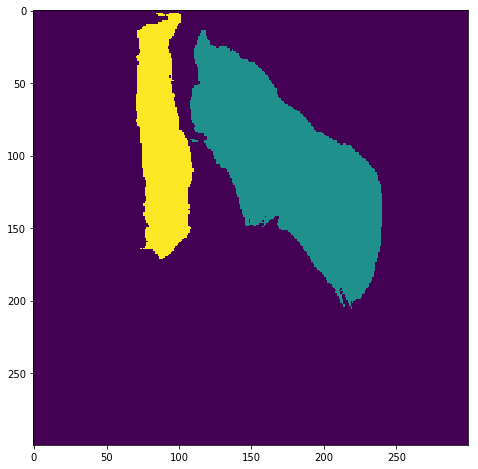

In [32]:
plt.imshow(preds[1][0].reshape(300, 300, -1).argmax(axis=-1).astype('float32'))

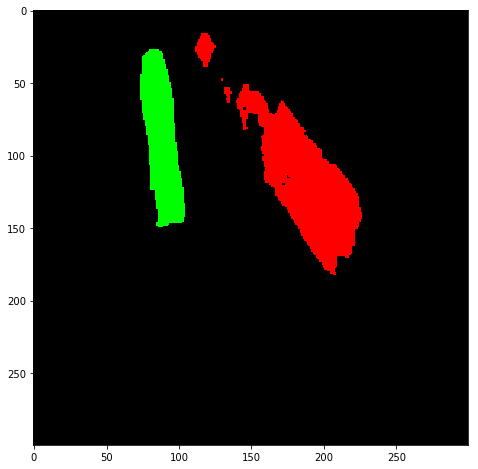

In [31]:
plt.imshow(gen.seg_db[sorted(train_keys)[888]].value.reshape(300, 300, -1)[:, :, 1:].astype('float32'))

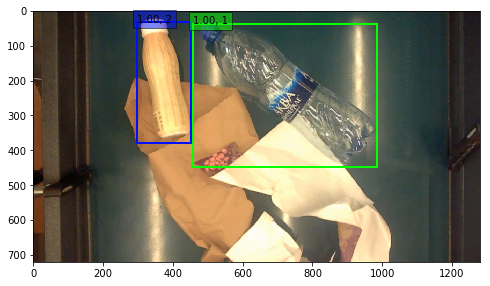

In [33]:
colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

for i, img in enumerate(images):
    plt.imshow(img / 255.)
    currentAxis = plt.gca()
    # Parse the outputs.
    if len(results[i]) > 0:
        det_label = results[i][:, 5:].argmax(axis=1) + 1
        det_conf = results[i][:, 5:].max(axis=1)
        det_xmin = results[i][:, 0]
        det_ymin = results[i][:, 1]
        det_xmax = results[i][:, 2]
        det_ymax = results[i][:, 3]

        # Get detections with confidence higher than 0.6.
#         top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]
        top_indices = range(len(det_label))

        top_conf = det_conf[top_indices]
        top_label_indices = det_label[top_indices].tolist()
        top_xmin = det_xmin[top_indices]
        top_ymin = det_ymin[top_indices]
        top_xmax = det_xmax[top_indices]
        top_ymax = det_ymax[top_indices]

        for i in range(top_conf.shape[0]):
            xmin = int(round(top_xmin[i] * img.shape[1]))
            ymin = int(round(top_ymin[i] * img.shape[0]))
            xmax = int(round(top_xmax[i] * img.shape[1]))
            ymax = int(round(top_ymax[i] * img.shape[0]))
            score = top_conf[i]
            label = int(top_label_indices[i])
    #         label_name = voc_classes[label - 1]
            display_txt = '{:0.2f}, {}'.format(score, label)
            coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
            color = colors[label]
            currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
            currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()

In [ ]:
conv4_3_f = []
fc7_f = []
conv6_2_f = []
conv7_2_f = []
conv8_2_f = []
pool6_f = []

In [ ]:
for i, img_p in enumerate(sorted(train_keys)[::4]):
    if i % 200 == 0:
        print(i)
    inputs = []
    images = []
    img_path = path_prefix + img_p
    img = image.load_img(img_path, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())
    inputs = preprocess_input(np.array(inputs))
    preds = model.predict(inputs, batch_size=1)
    conv4_3_f.append(preds[2].mean(axis=(0, 1, 2)))
    fc7_f.append(preds[3].mean(axis=(0, 1, 2)))
    conv6_2_f.append(preds[4].mean(axis=(0, 1, 2)))
    conv7_2_f.append(preds[5].mean(axis=(0, 1, 2)))
    conv8_2_f.append(preds[6].mean(axis=(0, 1, 2)))
    pool6_f.append(preds[7].squeeze())

train_tsne_samples = len(pool6_f)

In [ ]:
for i, img_p in enumerate(sorted(val_keys)):
    if i % 200 == 0:
        print(i)
    inputs = []
    images = []
    img_path = path_prefix + img_p
    img = image.load_img(img_path, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())
    inputs = preprocess_input(np.array(inputs))
    preds = model.predict(inputs, batch_size=1)
    conv4_3_f.append(preds[2].mean(axis=(0, 1, 2)))
    fc7_f.append(preds[3].mean(axis=(0, 1, 2)))
    conv6_2_f.append(preds[4].mean(axis=(0, 1, 2)))
    conv7_2_f.append(preds[5].mean(axis=(0, 1, 2)))
    conv8_2_f.append(preds[6].mean(axis=(0, 1, 2)))
    pool6_f.append(preds[7].squeeze())

val_tsne_samples = len(pool6_f) - train_tsne_samples

In [ ]:
for i, img_p in enumerate(sorted(adapt_keys)[::2]):
    if i % 200 == 0:
        print(i)
    inputs = []
    images = []
    img_path = img_p
    img = image.load_img(img_path, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())
    inputs = preprocess_input(np.array(inputs))
    preds = model.predict(inputs, batch_size=1)
    conv4_3_f.append(preds[2].mean(axis=(0, 1, 2)))
    fc7_f.append(preds[3].mean(axis=(0, 1, 2)))
    conv6_2_f.append(preds[4].mean(axis=(0, 1, 2)))
    conv7_2_f.append(preds[5].mean(axis=(0, 1, 2)))
    conv8_2_f.append(preds[6].mean(axis=(0, 1, 2)))
    pool6_f.append(preds[7].squeeze())

adapt_tsne_samples = len(pool6_f) - (train_tsne_samples + val_tsne_samples)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

In [ ]:
tsne = TSNE(verbose=10)
conv4_3_f_emb = tsne.fit_transform(conv4_3_f)

In [ ]:
df = pd.DataFrame(data=conv4_3_f_emb, columns=['x', 'y'])
classes = np.zeros(len(conv4_3_f_emb))
classes[train_tsne_samples:train_tsne_samples + val_tsne_samples] = 1
classes[-adapt_tsne_samples:] = 2
df['class'] = classes
sns.lmplot('x', 'y', data=df, fit_reg=False, hue='class', size=6)

In [ ]:
tsne = TSNE(verbose=10)
conv4_3_f_emb = tsne.fit_transform(conv4_3_f)
df = pd.DataFrame(data=conv4_3_f_emb, columns=['x', 'y'])
classes = np.zeros(len(conv4_3_f_emb))
classes[train_tsne_samples:train_tsne_samples + val_tsne_samples] = 1
classes[-adapt_tsne_samples:] = 2
df['class'] = classes
sns.lmplot('x', 'y', data=df, fit_reg=False, hue='class', size=6)

In [ ]:
tsne = TSNE(verbose=10)
fc7_f_emb = tsne.fit_transform(fc7_f)

In [ ]:
df = pd.DataFrame(data=fc7_f_emb, columns=['x', 'y'])
classes = np.zeros(len(fc7_f_emb))
classes[train_tsne_samples:train_tsne_samples + val_tsne_samples] = 1
classes[-adapt_tsne_samples:] = 2
df['class'] = classes
sns.lmplot('x', 'y', data=df, fit_reg=False, hue='class', size=6)

In [ ]:
tsne = TSNE(verbose=10)
fc7_f_emb = tsne.fit_transform(fc7_f)
df = pd.DataFrame(data=fc7_f_emb, columns=['x', 'y'])
classes = np.zeros(len(fc7_f_emb))
classes[train_tsne_samples:train_tsne_samples + val_tsne_samples] = 1
classes[-adapt_tsne_samples:] = 2
df['class'] = classes
sns.lmplot('x', 'y', data=df, fit_reg=False, hue='class', size=6)

In [ ]:
tsne = TSNE(verbose=10)
conv6_2_f_emb = tsne.fit_transform(conv6_2_f)

In [ ]:
df = pd.DataFrame(data=conv6_2_f_emb, columns=['x', 'y'])
classes = np.zeros(len(conv6_2_f_emb))
classes[train_tsne_samples:train_tsne_samples + val_tsne_samples] = 1
classes[-adapt_tsne_samples:] = 2
df['class'] = classes
sns.lmplot('x', 'y', data=df, fit_reg=False, hue='class', size=6)

In [ ]:
tsne = TSNE(verbose=10)
conv6_2_f_emb = tsne.fit_transform(conv6_2_f)
df = pd.DataFrame(data=conv6_2_f_emb, columns=['x', 'y'])
classes = np.zeros(len(conv6_2_f_emb))
classes[train_tsne_samples:train_tsne_samples + val_tsne_samples] = 1
classes[-adapt_tsne_samples:] = 2
df['class'] = classes
sns.lmplot('x', 'y', data=df, fit_reg=False, hue='class', size=6)

In [ ]:
tsne = TSNE(verbose=10)
conv7_2_f_emb = tsne.fit_transform(conv7_2_f)
df = pd.DataFrame(data=conv7_2_f_emb, columns=['x', 'y'])
classes = np.zeros(len(conv7_2_f_emb))
classes[train_tsne_samples:train_tsne_samples + val_tsne_samples] = 1
classes[-adapt_tsne_samples:] = 2
df['class'] = classes
sns.lmplot('x', 'y', data=df, fit_reg=False, hue='class', size=6)

In [ ]:
tsne = TSNE(verbose=10)
conv7_2_f_emb = tsne.fit_transform(conv7_2_f)
df = pd.DataFrame(data=conv7_2_f_emb, columns=['x', 'y'])
classes = np.zeros(len(conv7_2_f_emb))
classes[train_tsne_samples:train_tsne_samples + val_tsne_samples] = 1
classes[-adapt_tsne_samples:] = 2
df['class'] = classes
sns.lmplot('x', 'y', data=df, fit_reg=False, hue='class', size=6)

In [ ]:
tsne = TSNE(verbose=10)
conv8_2_f_emb = tsne.fit_transform(conv8_2_f)
df = pd.DataFrame(data=conv8_2_f_emb, columns=['x', 'y'])
classes = np.zeros(len(conv8_2_f_emb))
classes[train_tsne_samples:train_tsne_samples + val_tsne_samples] = 1
classes[-adapt_tsne_samples:] = 2
df['class'] = classes
sns.lmplot('x', 'y', data=df, fit_reg=False, hue='class', size=6)

In [ ]:
tsne = TSNE(verbose=10)
conv8_2_f_emb = tsne.fit_transform(conv8_2_f)
df = pd.DataFrame(data=conv8_2_f_emb, columns=['x', 'y'])
classes = np.zeros(len(conv8_2_f_emb))
classes[train_tsne_samples:train_tsne_samples + val_tsne_samples] = 1
classes[-adapt_tsne_samples:] = 2
df['class'] = classes
sns.lmplot('x', 'y', data=df, fit_reg=False, hue='class', size=6)

In [ ]:
tsne = TSNE(verbose=10)
pool6_f_emb = tsne.fit_transform(pool6_f)
df = pd.DataFrame(data=pool6_f_emb, columns=['x', 'y'])
classes = np.zeros(len(pool6_f_emb))
classes[train_tsne_samples:train_tsne_samples + val_tsne_samples] = 1
classes[-adapt_tsne_samples:] = 2
df['class'] = classes
sns.lmplot('x', 'y', data=df, fit_reg=False, hue='class', size=6)

In [ ]:
tsne = TSNE(verbose=10)
pool6_f_emb = tsne.fit_transform(pool6_f)
df = pd.DataFrame(data=pool6_f_emb, columns=['x', 'y'])
classes = np.zeros(len(pool6_f_emb))
classes[train_tsne_samples:train_tsne_samples + val_tsne_samples] = 1
classes[-adapt_tsne_samples:] = 2
df['class'] = classes
sns.lmplot('x', 'y', data=df, fit_reg=False, hue='class', size=6)

In [ ]:
model = SSD300_DANN(input_shape, num_classes=NUM_CLASSES, dann=True)
# model.load_weights('weights_SSD300.hdf5', by_name=True)
model.load_weights('dann/weights.10-1.45.hdf5', by_name=True)

In [ ]:
# img_ind = 980
# img = imresize(imread('../../frames/' + sorted(train_keys)[img_ind]), (720, 1280))
# y = bbox_util.assign_boxes(gt[sorted(train_keys)[img_ind]].copy())
# y[:, -8:] = priors
# img1, y1 = gen.random_sized_crop(img, gt[sorted(train_keys)[img_ind]].copy())
# y1 = bbox_util.assign_boxes(y1)
# y1[:, -8:] = priors
# results = bbox_util.detection_out(np.asarray([y, y1]))
# images=[img, img1]

In [ ]:
cap = cv2.VideoCapture('../../video_writer/video_8/video.avi')
cap.isOpened()

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('predicted_bb_part_adapt_3.avi', fourcc, 5.0, (640, 360))
out.isOpened()

In [ ]:
counter = 0
colors = (plt.cm.hsv(np.linspace(0, 1, 4)) * 255).tolist()
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        counter += 1
        if counter % 250 == 0:
            print(counter)
        frame = cv2.resize(frame, (640, 360)).astype('float64')
        frame_to_save = frame.copy()
        frame = cv2.resize(frame, (300, 300)).astype('float64')
        frame = frame[None, :, :, ::-1]
        frame = preprocess_input(np.array(frame))
        preds = model.predict(frame, batch_size=1)
        results = bbox_util.detection_out(preds[0])
        if len(results[0]) > 0:
            # Parse the outputs.
            det_label = results[0][:, 5:].argmax(axis=1) + 1
            det_conf = results[0][:, 5:].max(axis=1)
            det_xmin = results[0][:, 0]
            det_ymin = results[0][:, 1]
            det_xmax = results[0][:, 2]
            det_ymax = results[0][:, 3]

            # Get detections with confidence higher than 0.6.
#             top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]
            top_indices = range(len(det_label))

            top_conf = det_conf[top_indices]
            top_label_indices = det_label[top_indices].tolist()
            top_xmin = det_xmin[top_indices]
            top_ymin = det_ymin[top_indices]
            top_xmax = det_xmax[top_indices]
            top_ymax = det_ymax[top_indices]

            for i in range(top_conf.shape[0]):
                xmin = int(round(top_xmin[i] * frame_to_save.shape[1]))
                ymin = int(round(top_ymin[i] * frame_to_save.shape[0]))
                xmax = int(round(top_xmax[i] * frame_to_save.shape[1]))
                ymax = int(round(top_ymax[i] * frame_to_save.shape[0]))
                score = top_conf[i]
                label = int(top_label_indices[i])
        #         label_name = voc_classes[label - 1]
                display_txt = '{:0.2f}, {}'.format(score, label)
                color = colors[label]
                cv2.rectangle(frame_to_save, (xmin, ymin), (xmax, ymax), color, 2)
                cv2.putText(frame_to_save, display_txt, (xmin, ymin),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        out.write(frame_to_save.astype('uint8'))
    else:
        break

In [ ]:
all_preds = []
for i, img_p in enumerate(sorted(val_keys)):
    if i % 200 == 0:
        print(i)
    inputs = []
    images = []
    img_path = path_prefix + img_p
    img = image.load_img(img_path, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(img_path))
    inputs.append(img.copy())
    inputs = preprocess_input(np.array(inputs))
    preds = model.predict(inputs, batch_size=1)
    all_preds.extend(preds[0])

In [ ]:
result = bbox_util.detection_out(np.array(all_preds))

In [ ]:
truth = []
for k in sorted(val_keys):
    truth.append(gt[k])

In [ ]:
len(truth), len(result)

In [ ]:
from keras.callbacks import Callback
from sklearn.metrics import average_precision_score

class MAPCallback(Callback):
    def __init__(self, validation_data, batch_size, path_prefix,
                 gt, bbox_util, image_size=(300, 300),
                 map_iou_threshold=0.5, dann=True, model=None):
        super(MAPCallback, self).__init__()
        self.validation_data = validation_data
        self.nb_val_samples = len(validation_data)
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.gt = gt
        self.image_size = image_size
        self.bbox_util = bbox_util
        self.map_iou_threshold = map_iou_threshold
        self.dann = dann
        self.maps = []
        self.model = model
        
    def _generator(self):
        for i in np.arange(0, self.nb_val_samples - self.batch_size + 1,
                           self.batch_size):
            inputs = []
            targets = []
            for j in range(self.batch_size):
                key = self.validation_data[i + j]
                img_path = self.path_prefix + key
                img = imread(img_path)
                img = imresize(img, self.image_size).astype('float32')
                inputs.append(img)
                targets.append(self.gt[key])
            yield preprocess_input(np.array(inputs)), targets
            
    def iou(self, box, others):
        # compute intersection
        inter_upleft = np.maximum(others[:, :2], box[:2])
        inter_botright = np.minimum(others[:, 2:4], box[2:])
        inter_wh = inter_botright - inter_upleft
        inter_wh = np.maximum(inter_wh, 0)
        inter = inter_wh[:, 0] * inter_wh[:, 1]
        # compute union
        area_pred = (box[2] - box[0]) * (box[3] - box[1])
        area_gt = (others[:, 2] - others[:, 0])
        area_gt *= (others[:, 3] - others[:, 1])
        union = area_pred + area_gt - inter
        # compute iou
        iou = inter / union
        return iou
            
    def eval_map(self, y_true, y_pred, map_iou_threshold):
        nb_imgs = len(y_true)
        targets = []
        preds = []
        for i in range(nb_imgs):
            true_bbs = np.array(y_true[i])
            pred_bbs = np.array(y_pred[i])
            if len(true_bbs) == 0 and len(pred_bbs) == 0:
                continue
            # assignment
            for pred_bb in pred_bbs:
                iou = self.iou(pred_bb[:4], true_bbs[:, :4])
                true_label = np.zeros_like(pred_bb[4:])
                if len(iou) == 0 or iou.max() < map_iou_threshold:
                    true_label[0] = 1
                else:
                    idx = iou.argmax()
                    true_label[1:] = true_bbs[idx, 4:]
                targets.append(true_label)
                preds.append(pred_bb[4:])
            for true_bb in true_bbs:
                iou = self.iou(true_bb[:4], pred_bbs[:, :4])
                if len(iou) == 0 or iou.max() < map_iou_threshold:
                    true_label = np.zeros(len(true_bb) - 3)
                    true_label[1:] = true_bb[4:]
                    pred_label = np.zeros_like(true_label)
                    pred_label[0] = 1
                    targets.append(true_label)
                    preds.append(pred_label)
        targets = np.array(targets)
        score = average_precision_score(targets, preds, average=None)
        return score            

    def on_epoch_end(self, epoch, logs={}):
        y_true = []
        y_pred = []
        for inputs, targets in self._generator():
            preds = self.model.predict_on_batch(inputs)
            if self.dann:
                results = self.bbox_util.detection_out(preds[0])
            else:
                results = self.bbox_util.detection_out(preds)
            y_true.extend(targets)
            y_pred.extend(results)
        score = self.eval_map(y_true, y_pred, self.map_iou_threshold)
        print('MAP for epoch {} is {:.4f}, AP is {}'.format(epoch, score[1:].mean(), score))
        self.maps.append(score)

In [ ]:
mapc = MAPCallback(val_keys, 20, path_prefix, gt,
                   bbox_util, map_iou_threshold=0.5, dann=False, model=model)

In [ ]:
mapc.on_epoch_end(0)

In [41]:
cap = cv2.VideoCapture('../../frames/musor_epta.m4v')
cap.isOpened()
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('predicted_seg_1.avi', fourcc, 30.0, (1280, 360))
out.isOpened()

True

In [43]:
counter = 0
colors = (plt.cm.hsv(np.linspace(0, 1, 4)) * 255).tolist()
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        counter += 1
        if counter % 250 == 0:
            print(counter)
        frame = cv2.resize(frame, (640, 360)).astype('float64')
        frame_to_save = frame.copy()
        frame = cv2.resize(frame, (300, 300)).astype('float64')
        frame = frame[None, :, :, ::-1]
        frame = preprocess_input(np.array(frame))
        preds = model.predict(frame, batch_size=1)
        results = bbox_util.detection_out(preds[0])
        if len(results[0]) > 0:
            # Parse the outputs.
            det_label = results[0][:, 5:].argmax(axis=1) + 1
            det_conf = results[0][:, 5:].max(axis=1)
            det_xmin = results[0][:, 0]
            det_ymin = results[0][:, 1]
            det_xmax = results[0][:, 2]
            det_ymax = results[0][:, 3]

            # Get detections with confidence higher than 0.6.
            top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

            top_conf = det_conf[top_indices]
            top_label_indices = det_label[top_indices].tolist()
            top_xmin = det_xmin[top_indices]
            top_ymin = det_ymin[top_indices]
            top_xmax = det_xmax[top_indices]
            top_ymax = det_ymax[top_indices]

            for i in range(top_conf.shape[0]):
                xmin = int(round(top_xmin[i] * frame_to_save.shape[1]))
                ymin = int(round(top_ymin[i] * frame_to_save.shape[0]))
                xmax = int(round(top_xmax[i] * frame_to_save.shape[1]))
                ymax = int(round(top_ymax[i] * frame_to_save.shape[0]))
                score = top_conf[i]
                label = int(top_label_indices[i])
        #         label_name = voc_classes[label - 1]
                display_txt = '{:0.2f}, {}'.format(score, label)
                color = colors[label]
                cv2.rectangle(frame_to_save, (xmin, ymin), (xmax, ymax), color, 2)
                cv2.putText(frame_to_save, display_txt, (xmin, ymin),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        new_frame = np.zeros((360, 1280, 3))
        new_frame[:, :640] = frame_to_save
        classes = imresize(preds[1][0].reshape(300, 300, -1), (360, 640)).argmax(axis=-1)
        new_frame_seg = new_frame[:, 640:]
        new_frame_seg[:, :, 0][classes == 1] = 255
        new_frame_seg[:, :, 1][classes == 2] = 255
        new_frame_seg[:, :, 2][classes == 3] = 255
#         out.write(frame_to_save.astype('uint8'))
        out.write(new_frame.astype('uint8'))
    else:
        break

250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
